In [1]:
!pip install transformers
!pip install sentencepiece
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
import json
import random
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import re
import numpy as np
import pandas as pd
import emoji
from transformers import *
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *
from sklearn.utils import *
import math
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [6]:
def Diff(a,b):
    return list(set(a) -set(b))

def re_sub(pattern, repl,text):
    return re.sub(pattern, repl, text)


def preprocess_sent(sent):
    sent = re.sub(r"http\S+", " ", sent.lower())
    sent = re.sub(r"@\S+", "@user", sent)

    #print(sent)
    sent = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "",sent)
    sent = emoji.demojize(sent)
    sent = re_sub(r"[:\*]", " ",sent)
    sent = re.sub(r"[<\*>]", " ",sent)
    sent = sent.replace("&amp;", " ")
    sent = sent.replace("ðŸ¤§", " ")
    sent = sent.replace("\n", " ")
    sent = sent.replace("ðŸ˜¡", " ")
    return sent

def evalMetric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    mf1Score = f1_score(y_true, y_pred, average='macro')
    f1Score  = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area_under_c = auc(fpr, tpr)
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)
    return {"accuracy": accuracy, 'mF1Score': mf1Score, 'f1Score': f1Score, 'auc': area_under_c, 
            'precision': precisionScore, 'recall': recallScore}
#Creating an attention mask - For actual tokens its set to 1, for padding tokens its set to 0
def create_attention_masks(input_ids):
    attention_masks = []
    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return np.array(attention_masks)
#tokenizes the data
def getFeaturesandLabel(X,y):
    sentences = list(X)
    sentences = ["[CLS] "+ preprocess_sent(i) + " [SEP]"for i in sentences]
    tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:512], tqdm(sentences)))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenizer_texts)]
    input_ids = pad_sequences(sequences = input_ids, maxlen = veParams['max_length'], dtype = 'long', padding='post', truncating='post')
    attention_masks_data = create_attention_masks(input_ids)
    X_data = torch.tensor(input_ids)
    attention_masks_data = torch.tensor(attention_masks_data)
    y_data = torch.tensor(y)
    return X_data, attention_masks_data, y_data


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
  
def fix_the_random(seed_val = 42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed_val) 
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)


In [7]:
# Class for weighted bert for sentence classification
class SC_weighted_BERT(BertPreTrainedModel):
    def __init__(self, config,weights):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.weights=weights
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights))
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss = self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

def getPerformanceOfLoader(test_dataloader):
    model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in test_dataloader:
    #print(batch)
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
  
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        pred_flat = np.argmax(logits, axis=1).flatten()
        predictions.extend(pred_flat)
        true_labels.extend(label_ids)

    df = pd.DataFrame()
    df['id']=testData['Data']
    df['target'] = predictions

    return df

fix_the_random(2021)

In [8]:
import pandas as pd
# Change The Datasets as Per Your requirement

trainData =  pd.read_csv("/content/gdrive/MyDrive/Final Project/Code/Dataset/Dataset_BHS_MJN_Train.csv")
valData =  pd.read_csv("/content/gdrive/MyDrive/Final Project/Code/Dataset/Dataset_BHS_MJN_Validation.csv")
testData =  pd.read_csv("/content/gdrive/MyDrive/Final Project/Code/Dataset/Dataset_BHS_MJN_Test.csv")

In [9]:
trainData

,Data,Catergory,Label
0,গাড়ি উড়োজাহাজ আর হেলিকপটার তো খিরিসটানরা বানাই...,Religious,0
1,ওরে চা খাওয়ান সব ঠিক হয়ে যাবে??,Religious,0
2,আমার জাছে আয় চুদে তোর ভদার রস বের করে দিবো আয় ...,Political,1
3,"আপনি ভাল বলেছেন ,ও যদি আসতে চাই আপনি গ্রহণ করি...",Sports,0
4,আম্পায়ার এর ডিসিসনে সংসয় থাকলেও সেটা আগে দিত...,Sports,0
...,...,...,...
6044,ডিভোর্সের তারিখ টা ঠিক করে রাখছিস????,Enternainment,0
6045,কুত্তায় ও খাইবেনা ওর পঁচা দেহ,Others,1
6046,একেবারে সেফুদা,Others,0
6047,আপনার জন্ম টা যে পতিতালয় কনডম দূর্ঘটনায় হয়েছে ...,Religious,1


In [10]:
valData

,Data,Catergory,Label
0,কাকা ফোন না ম্বার টা দিবেন,Religious,0
1,"যুগটা বিজ্ঞানের, গলাটা মৌলবাদের!",Religious,1
2,টাকা আমরা দিব,Enternainment,0
3,টাকলু হালা শেফুদর,Enternainment,1
4,আপনাদের নিউজের তারেক দিচ্ছেন না কেন,Political,0
...,...,...,...
1289,"একটা পাডা আরেক টা পাডি,,,,লগে এত্তগুলা ছাগলের ...",Enternainment,0
1290,কুকুরের লেজের মতয় ছাএলিগ জতয় ছাইবে সোজা করতে ক...,Political,1
1291,এগুলো জামায়াত বিএনপি র গভীর ষড়যন্ত্র,Political,0
1292,ভাই সাবাস চালিয়ে যান হয় তো কোন এক দিন আপনার কথ...,Political,0


In [11]:
# features: X
# ground truth: y
X_tn, y_tn = list(trainData['Data']), list(trainData['Label'])
X_v, y_v = list(valData['Data']), list(valData['Label'])
X_ts, y_ts = list(testData['Data']), list(testData['Label'])


In [12]:
X_tn

['গাড়ি উড়োজাহাজ আর হেলিকপটার তো খিরিসটানরা বানাইসে তাইলে ভন্ড হাফিজুর তা কেন চড়েন !! অসভ্ভো ভন্ড কোথাকার',
 'ওরে চা খাওয়ান সব ঠিক হয়ে যাবে??',
 'আমার জাছে আয় চুদে তোর ভদার রস বের করে দিবো আয় আমার কাছে আয়',
 'আপনি ভাল বলেছেন ,ও যদি আসতে চাই আপনি গ্রহণ করিবেন। কিছুদিন পর যখন আবার চলে যাবে অন্য কাহারো সাথে ,আবার আপনি গ্রহণ করবেন তাই না।।।। কিছুদিনের জন্য আপনাকে পাবনায় নিয়ে চিকিৎসা করা হোক।',
 'আম্পায়ার এর ডিসিসনে সংসয় থাকলেও সেটা আগে দিতে হবে এত বড় আম্পায়ার এখন ও তৈরি হয় নি যে মাঠে খেলা দেখে সব ডিসিসান দিতে পারবে।। সেটা সংসয় থাকবে সেটা থার্ড আম্পায়ারের কাছে শুনে তার পর দেয়।আবাল রা। বাল ও বোঝে না ,হারে গেছে বলে রাগ হচ্ছে,মে ভালো খেলবে সে জিতবে।।।',
 'এইসব পাগল ছাগল টিভির পর্দায় আসে কোথার থেকে',
 'বাল পাখনা কথা বলে',
 'হায়রে মূর্খের বাচ্চা তুই তো ছাগলের তিন নাম্বার বাচ্চা না খাইয়া নাছোচ',
 'এই কুত্তার বাচ্চা কে কোথায় পাবো !!?',
 'আল্লাহ সুন্নি নামেই এদের ভন্ডামীদের হেদায়াত নছীব করুন',
 'কই রাণী কই চুতমারাণী কই খালেদা আর কই কাওয়া কাদের।',
 'তোমাকে ছোটবেলাতেই কিউট লাগতো। বড়ো হয়ে আস্

In [13]:
y_tn

[0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,


In [14]:
veParams={
    'max_length':128,
    'path_files': 'bert-base-multilingual-uncased',
    'what_bert':'weighted',
    'batch_size':16,
    'is_train':True,
    'learning_rate':2e-5,
    'epsilon':1e-8,
    'random_seed':30,
    'epochs':10,
    'to_save':True,
    'frac':0.8,
    'outputDir':'/content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed'
}

tokenizer = BertTokenizer.from_pretrained(veParams['path_files'], do_lower_case = True)

X_train, attention_masks_train, y_train = getFeaturesandLabel(X_tn,y_tn)
X_val, attention_masks_val, y_val = getFeaturesandLabel(X_v,y_v)
X_test, attention_masks_test, y_test = getFeaturesandLabel(X_ts,y_ts)

#Dataset wrapping tensors.
train_data = TensorDataset(X_train, attention_masks_train, y_train)
val_data = TensorDataset(X_val, attention_masks_val, y_val)
test_data = TensorDataset(X_test, attention_masks_test, y_test)

#Samples elements randomly. If without replacement(default), then sample from a shuffled dataset.
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)
test_sampler = SequentialSampler(test_data)

#represents a Python iterable over a dataset
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = veParams['batch_size'])
validation_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = veParams['batch_size'])
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = veParams['batch_size'])

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/3da6b6aad5111664db74322f2158b7f93e09a717/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/3da6b6aad5111664db74322f2158b7f93e09a717/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/3da6b6aad5111664db74322f2158b7f93e09a717/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 30

In [15]:
from sklearn.metrics import accuracy_score

def select_model(type_of_model,path,weights=None,label_list=None):
    if(type_of_model=='weighted'):
        model = SC_weighted_BERT.from_pretrained(
        path, # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification             # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        weights=weights
    )
    else:
        print("Error in model name!!!!")
    return model

class_weights = [sum(y_tn)/len(y_tn), 1 -sum(y_tn)/len(y_tn)]

print(class_weights)

torch.cuda.empty_cache()

model = select_model(veParams['what_bert'], veParams['path_files'], class_weights)

import numpy as np
def getProb(temp):
    t = np.exp(temp)
    return t[1]/(sum(t))

model.cuda()
bestValAcc  = 0
bestValMF1  = 0
besttest_df  = None
bestEpochs = -1

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = veParams['epochs']
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
training_stats = []
loss_values = []
vloss_values = []
tacc_values = []
vacc_values = []


for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    t_accuracy = 0
    nb_t_steps = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        with torch.no_grad():
          logits = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = logits[0]
    
        # t_accuracy = outputs[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids_t = b_labels.to('cpu').numpy()

        # loss_t = np.argmax(loss_t, axis=0)
        # label_ids_t = np.argmax(label_ids_t, axis=0)

        # Calculate the accuracy for this batch of test sentences.
        tmp_t_accuracy = flat_accuracy(logits, label_ids_t)

        # Accumulate the total accuracy.
        t_accuracy += tmp_t_accuracy

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        nb_t_steps += 1

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader) 
    avg_train_acc = t_accuracy/nb_t_steps

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    tacc_values.append(avg_train_acc)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Accuracy: {0:.2f}".format(avg_train_acc))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
 
    # Evaluate data for one epoch
    origValValue = []
    preValValue  = []
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Accumulate the validation loss.
        eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
      
        origValValue.extend(label_ids)
        valPred_flat = np.argmax(logits, axis=1).flatten()
        preValValue.extend(valPred_flat)
        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    avg_val_loss = eval_loss / len(validation_dataloader)
    avg_val_acc = eval_accuracy/nb_eval_steps

    # Store the loss value for plotting the learning curve.
    vloss_values.append(avg_val_loss)
    vacc_values.append(avg_val_acc)

    valMf1Score = f1_score(origValValue, preValValue, average='macro')
#    if ((eval_accuracy/nb_eval_steps) > bestValAcc):
    if (valMf1Score > bestValMF1):
         bestEpochs = epoch_i
         bestValMF1 = valMf1Score
         bestValAcc  = eval_accuracy/nb_eval_steps
         besttest_df = getPerformanceOfLoader(test_dataloader)
         model.save_pretrained(veParams['outputDir'])
         tokenizer.save_pretrained(veParams['outputDir'])
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

print(bestEpochs)

besttest_df.head()

testData['pred']=besttest_df['target']

evalMetric(list(testData['Label']), list(testData['pred']))

testData.to_csv(veParams['outputDir']+"kaEn_test_pred.csv",index=False)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/3da6b6aad5111664db74322f2158b7f93e09a717/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 105879
}

loading weights file pytorch_model.bin

[0.4704909902463217, 0.5295090097536783]


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing SC_weighted_BERT: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing SC_weighted_BERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SC_weighted_BERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SC_weighted_BERT were not initialized from the model checkpoint at bert-base-multilingual-uncased and are


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    379.    Elapsed: 0:00:21.
  Batch    80  of    379.    Elapsed: 0:00:41.
  Batch   120  of    379.    Elapsed: 0:01:00.
  Batch   160  of    379.    Elapsed: 0:01:20.
  Batch   200  of    379.    Elapsed: 0:01:39.
  Batch   240  of    379.    Elapsed: 0:01:59.
  Batch   280  of    379.    Elapsed: 0:02:18.
  Batch   320  of    379.    Elapsed: 0:02:37.
  Batch   360  of    379.    Elapsed: 0:02:57.

  Average training loss: 0.55
  Accuracy: 0.72
  Training epcoh took: 0:03:06

Running Validation...


Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/special_tokens_map.json


  Accuracy: 0.79
  Validation took: 0:00:23

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    379.    Elapsed: 0:00:19.
  Batch    80  of    379.    Elapsed: 0:00:39.
  Batch   120  of    379.    Elapsed: 0:00:58.
  Batch   160  of    379.    Elapsed: 0:01:17.
  Batch   200  of    379.    Elapsed: 0:01:37.
  Batch   240  of    379.    Elapsed: 0:01:56.
  Batch   280  of    379.    Elapsed: 0:02:15.
  Batch   320  of    379.    Elapsed: 0:02:35.
  Batch   360  of    379.    Elapsed: 0:02:54.

  Average training loss: 0.41
  Accuracy: 0.82
  Training epcoh took: 0:03:03

Running Validation...


Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/special_tokens_map.json


  Accuracy: 0.84
  Validation took: 0:00:22

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    379.    Elapsed: 0:00:19.
  Batch    80  of    379.    Elapsed: 0:00:39.
  Batch   120  of    379.    Elapsed: 0:00:58.
  Batch   160  of    379.    Elapsed: 0:01:17.
  Batch   200  of    379.    Elapsed: 0:01:37.
  Batch   240  of    379.    Elapsed: 0:01:56.
  Batch   280  of    379.    Elapsed: 0:02:15.
  Batch   320  of    379.    Elapsed: 0:02:35.
  Batch   360  of    379.    Elapsed: 0:02:54.

  Average training loss: 0.31
  Accuracy: 0.87
  Training epcoh took: 0:03:03

Running Validation...


Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/special_tokens_map.json


  Accuracy: 0.86
  Validation took: 0:00:23

======== Epoch 4 / 10 ========
Training...
  Batch    40  of    379.    Elapsed: 0:00:19.
  Batch    80  of    379.    Elapsed: 0:00:39.
  Batch   120  of    379.    Elapsed: 0:00:58.
  Batch   160  of    379.    Elapsed: 0:01:18.
  Batch   200  of    379.    Elapsed: 0:01:37.
  Batch   240  of    379.    Elapsed: 0:01:56.
  Batch   280  of    379.    Elapsed: 0:02:15.
  Batch   320  of    379.    Elapsed: 0:02:35.
  Batch   360  of    379.    Elapsed: 0:02:54.

  Average training loss: 0.24
  Accuracy: 0.91
  Training epcoh took: 0:03:03

Running Validation...
  Accuracy: 0.85
  Validation took: 0:00:10

======== Epoch 5 / 10 ========
Training...
  Batch    40  of    379.    Elapsed: 0:00:19.
  Batch    80  of    379.    Elapsed: 0:00:39.
  Batch   120  of    379.    Elapsed: 0:00:58.
  Batch   160  of    379.    Elapsed: 0:01:17.
  Batch   200  of    379.    Elapsed: 0:01:37.
  Batch   240  of    379.    Elapsed: 0:01:56.
  Batch   280  of

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/special_tokens_map.json


  Accuracy: 0.87
  Validation took: 0:00:22

======== Epoch 7 / 10 ========
Training...
  Batch    40  of    379.    Elapsed: 0:00:19.
  Batch    80  of    379.    Elapsed: 0:00:39.
  Batch   120  of    379.    Elapsed: 0:00:58.
  Batch   160  of    379.    Elapsed: 0:01:18.
  Batch   200  of    379.    Elapsed: 0:01:37.
  Batch   240  of    379.    Elapsed: 0:01:56.
  Batch   280  of    379.    Elapsed: 0:02:16.
  Batch   320  of    379.    Elapsed: 0:02:35.
  Batch   360  of    379.    Elapsed: 0:02:54.

  Average training loss: 0.11
  Accuracy: 0.97
  Training epcoh took: 0:03:03

Running Validation...


Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/special_tokens_map.json


  Accuracy: 0.87
  Validation took: 0:00:22

======== Epoch 8 / 10 ========
Training...
  Batch    40  of    379.    Elapsed: 0:00:19.
  Batch    80  of    379.    Elapsed: 0:00:39.
  Batch   120  of    379.    Elapsed: 0:00:58.
  Batch   160  of    379.    Elapsed: 0:01:17.
  Batch   200  of    379.    Elapsed: 0:01:37.
  Batch   240  of    379.    Elapsed: 0:01:56.
  Batch   280  of    379.    Elapsed: 0:02:15.
  Batch   320  of    379.    Elapsed: 0:02:35.
  Batch   360  of    379.    Elapsed: 0:02:54.

  Average training loss: 0.08
  Accuracy: 0.98
  Training epcoh took: 0:03:03

Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:10

======== Epoch 9 / 10 ========
Training...
  Batch    40  of    379.    Elapsed: 0:00:19.
  Batch    80  of    379.    Elapsed: 0:00:39.
  Batch   120  of    379.    Elapsed: 0:00:58.
  Batch   160  of    379.    Elapsed: 0:01:17.
  Batch   200  of    379.    Elapsed: 0:01:36.
  Batch   240  of    379.    Elapsed: 0:01:56.
  Batch   280  of

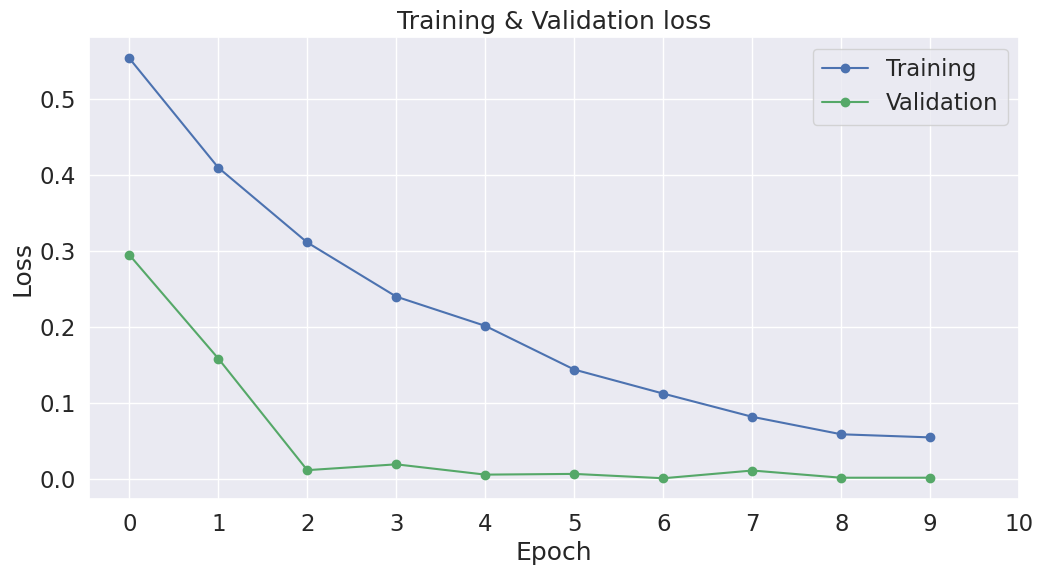

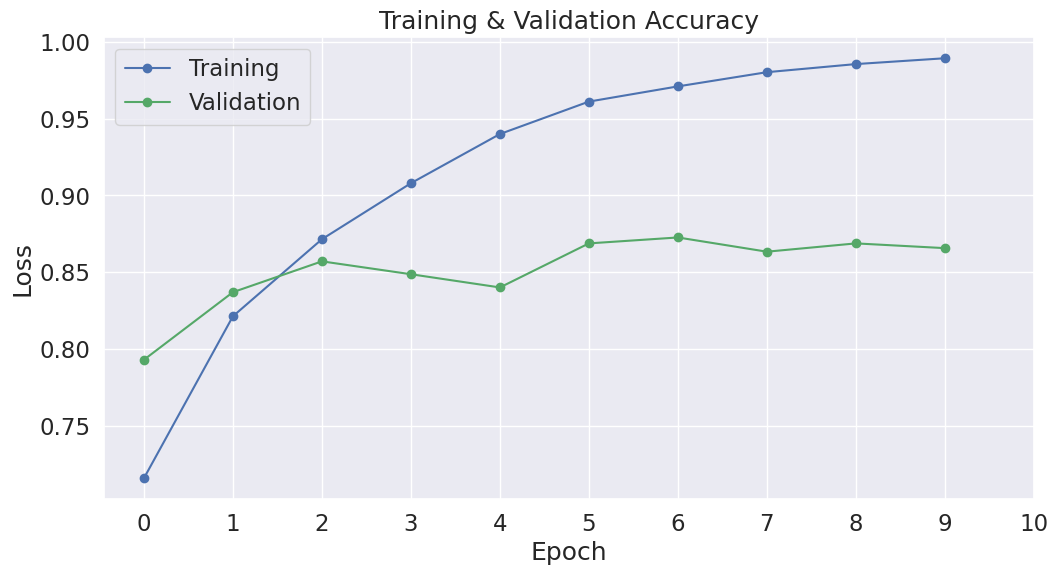

In [27]:
import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="Training")
plt.plot(vloss_values, 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8 ,9 , 10])
plt.show()


# Plot the learning curve.
plt.plot(tacc_values, 'b-o', label="Training")
plt.plot(vacc_values, 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8 ,9 , 10])
plt.show()

In [17]:
from transformers import AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("/content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed")
modelLoaded = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed")

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed/config.json
Model config BertConfig {
  "_name_or_path": "/content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed",
  "architectures": [
    "SC_weighted_BERT"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transf

In [18]:
testData =  pd.read_csv("/content/gdrive/MyDrive/Final Project/Code/Dataset/Dataset_BHS_MJN_Test.csv")
# testData
# features: X
# ground truth: y 
X_ts, y_ts = list(testData['Data']), list(testData['Label'])


In [19]:
X_ts

['পরিমনী বাংলার মানুষের কাছে এক বড় পতিতার নাম',
 'আসসালামু আলাইকুম ভাই অসংখ্য ধন্যবাদ আপনাকে সত্যি তা বোঝার জন্য',
 'এই কুত্তার বাচ্চা তুই কি অলিপুরিকে চিনিস ? যাকে ভিডিওতে অলিপুরি বলছিস সে কি অলিপুরি বেটা ছাগল',
 'সালমান মোক্তাদির ভক্ত করা তাদের দেখতে চাই হালায় ক্যামনে হয় হয় সুইপারম্যান 😁',
 'সব সহ্য করতে হবে!',
 'পটলের মতো সাইজ নিয়ে নাচতে আসছে!!!',
 'তর ভাবি সাবধানে কথা বল',
 'সঞ্জয় শীল তারা দালাল',
 'উলঙ্গ কথাটা যদি শুনতে এতোটাই খারাপ লাগে বা কুরুচিপূর্ণ মনে হয়, তাহলে এভাবে উলঙ্গের মতো চলাচল করেন কেনো!!!!যাহা কেউ বল্লে শুনতে খারাপ লাগে তা আবার নিজেই করতেছেন।',
 'বাংলাদেশ ফুটবলে যতই র\u200d্যাংকিং পিছাক না কেন। কিন্ত মারামারিতে রেংকিং নাম্বার ওয়ান',
 'এই ওসির বিরুদ্ধে আরো অনেক ঘটনা আছে',
 'শুভ কামনা রইল',
 'একটা লেঙ্গটাকে নিয়ে উঠে পড়ে লেগেছে সাংবাদিক\nতাকে বলে দাও নেক্সট পারফর্মেন্স যাতে লুঙ্গি ছাড়া হয়',
 'এ জাতির উপর আল্লাহর গজব পড়বে।',
 'সমাজে নষ্টামি করা এই বাঝে মেয়েটি অধিকার রাখতে পারে না, ওরে দৌলদিয়া পাড়ায় পাঠিয়ে দেয়া হোক,',
 'নাস্তিকের বাচ্ছা সেফুদা',
 'ছাত্রলীগ! ছাত্র+আওয়াম

In [20]:
y_ts

[1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,


In [21]:
import pandas as pd
def Diff(a,b):
    return list(set(a) -set(b))

def re_sub(pattern, repl,text):
    return re.sub(pattern, repl, text)


def preprocess_sent(sent):
    sent = re.sub(r"http\S+", " ", sent.lower())
    sent = re.sub(r"@\S+", "@user", sent)

    #print(sent)
    sent = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "",sent)
    sent = emoji.demojize(sent)
    sent = re_sub(r"[:\*]", " ",sent)
    sent = re.sub(r"[<\*>]", " ",sent)
    sent = sent.replace("&amp;", " ")
    sent = sent.replace("ðŸ¤§", " ")
    sent = sent.replace("\n", " ")
    sent = sent.replace("ðŸ˜¡", " ")
    return sent

def create_attention_masks(input_ids):
    attention_masks = []
    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return np.array(attention_masks)

def getFeaturesandLabelTest(X):
    sentences = list(X)
    sentences = ["[CLS] "+ preprocess_sent(i) + " [SEP]"for i in sentences]
    tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t, truncation=True, max_length=128)[:512], tqdm(sentences)))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenizer_texts)]
    input_ids = pad_sequences(sequences = input_ids, maxlen = veParams['max_length'], dtype = 'long', padding='post', truncating='post')
    attention_masks_data = create_attention_masks(input_ids)
    X_data = torch.tensor(input_ids)
    attention_masks_data = torch.tensor(attention_masks_data)
    return X_data, attention_masks_data

veParams={
    'max_length':128,
    'path_files': 'bert-base-multilingual-uncased',
	#'path_files': 'google/muril-base-cased',
    'what_bert':'weighted',
    'batch_size':16,
    'is_train':True,
    'learning_rate':2e-5,
    'epsilon':1e-8,
    'random_seed':30,
    'epochs':10,
    'to_save':True,
    'frac':0.8,
    'outputDir':'/content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada_D/Code-Mixed'
    # /content/drive/MyDrive/IndicLang/Kannada/Code-Mixed
}

In [22]:
def hateSpeechAnalysis(X_in):
    X_test, attention_masks_test = getFeaturesandLabelTest(X_in)
    # X_test
    # #Dataset wrapping tensors.
    test_data = TensorDataset(X_test, attention_masks_test)
    test_data
    # #Samples elements randomly. If without replacement(default), then sample from a shuffled dataset.
    test_sampler = SequentialSampler(test_data)

    # #represents a Python iterable over a dataset
    test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = veParams['batch_size'])
    testOutputs = testPerformanceOfLoader(test_dataloader)
    return testOutputs
# test_dataloader

In [23]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

def testPerformanceOfLoader(test_dataloader):
    # model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in test_dataloader:
    #print(batch)
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask = batch
  
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = modelLoaded(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        # label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        pred_flat = np.argmax(logits, axis=1).flatten()
        predictions.extend(pred_flat)
        # true_labels.extend(label_ids)

    df = pd.DataFrame()
    # df['id']=testData['sentence']
    # df['target'] = predictions

    return predictions

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [24]:
# X_in = ['সালা হারামি একটা']
y_out = hateSpeechAnalysis(X_ts)
# int(y_out[0])
# if int(y_out[0]) == 0 :
#   print("It is not a hate speech")
# else:
#   print("It is a hate speech")
# if 
# output = int(y_out[0])
# output

100%|██████████| 1294/1294 [00:00<00:00, 16502.21it/s]


RuntimeError: ignored

In [ ]:
# output = int(y_out)
# output

In [ ]:
predictions= np.array(y_out)
predictions

In [ ]:
print(classification_report(y_ts, predictions, target_names = ['NH (Class 0)','Hate (Class 1)']))

#### Confusion Matrix

In [ ]:
cf_matrix = confusion_matrix(y_ts,predictions)

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, fmt='d',cmap='Blues' )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['NH', 'Hate'])

# set y-axis label and ticks
ax.set_ylabel("Actual labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['NH', 'Hate'])

# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()

#### ROC AUC

In [ ]:
auc = roc_auc_score(y_ts,predictions)
auc

In [ ]:
# calculate roc curves
# ns_fpr, ns_tpr, _ = roc_curve(test_lbls,predictions)
fpr, tpr, _ = roc_curve(y_ts,predictions)
# plot the roc curve for the model
# plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ROC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()